Mount Drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


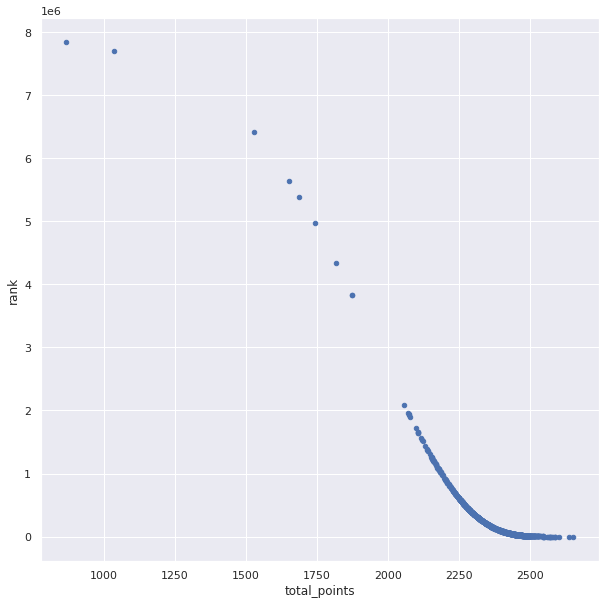

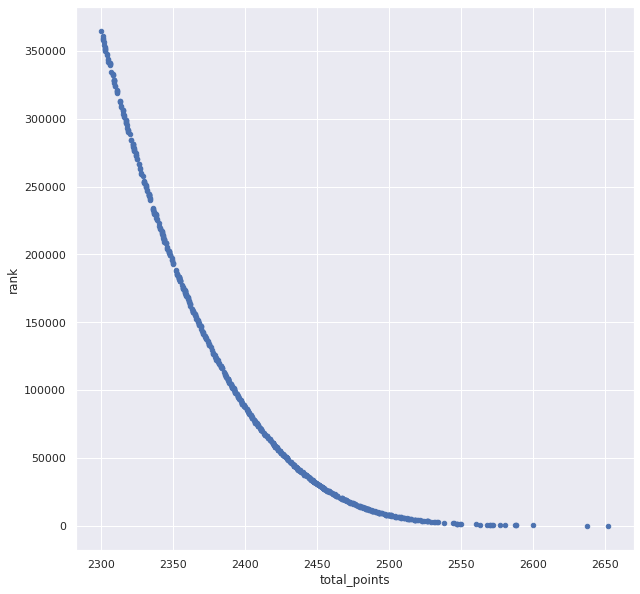

In [ ]:
import requests
import pandas as pd
import seaborn as sns
sns.set()

def Access_URL(url):
    r = requests.get(url) 
    json = r.json() 
    return json 


team_ids = range(1, 1000, 1)
overall_dataframe = pd.DataFrame()
for id in team_ids:
    previous_seasons = Access_URL(f'https://fantasy.premierleague.com/api/entry/{id}/history/')['past']
    df_player = pd.DataFrame(previous_seasons)
    df_player['id'] = id
    overall_dataframe = pd.concat([overall_dataframe, df_player])

last_season = overall_dataframe.loc[overall_dataframe['season_name'] == '2020/21']
last_season.plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

# %%
mask = last_season['total_points'] >= 2300
last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

# # %%
mask = (last_season['total_points'] >= 2300) & (last_season['total_points'] <= 2400)
# last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

In [ ]:
last_season[last_season['total_points'] == 2244] # Without wildcards -- 2245
# Top 8.4% of managers

,season_name,total_points,rank,id
13,2020/21,2244.0,638151.0,226
5,2020/21,2244.0,638403.0,862


In [ ]:
last_season[last_season['total_points'] == 2376] # With all chips -- 2376
# Top 1.76% of managers

,season_name,total_points,rank,id
2,2020/21,2376.0,131932.0,868


Install Boruta and BorutaShap

In [ ]:
! pip install Boruta
! pip install BorutaShap
! pip install shap-hypetune

     |████████████████████████████████| 56 kB 1.9 MB/s 
     |████████████████████████████████| 371 kB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509235 sha256=7f94f2cf849167060ef4b443ea6b4c74dcff0877d35d8e27b4794c41c32b7c88
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


Encode all features 

In [ ]:
def preprocess_data(df):
  # Drop indexing features
  df = df.drop(columns = ['player_name', 'kickoff_time', 'season', 'GW'])
  # Binary encoding
  for col in df.columns:
    df[col] = df[col].replace({True:1, False:0})
  # One hot encodings
  ohe_cols = []
  for col in df.select_dtypes(include='object').columns:
      ohe_cols.append(col)
  df = pd.get_dummies(df, columns=ohe_cols, prefix=ohe_cols)

  return df

df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
df = df[df['season'] == 2019]
df.drop(['team', 'opponent_team'], inplace = True, axis = 1)
df = preprocess_data(df)
df

,value,total_points,was_home,selected,substitution,supporters,common_transfer,double_week,penalties_missed_shift,team_penalty_shift,team_win_perc_shift,penalties_saved_shift,bps_shift,opp_team_win_perc_shift,ict_index_shift,xGBuildup_shift,xG_shift,xGChain_shift,bonus_shift,key_passes_shift,win_shift,played_67_shift,saves_shift,npxG_shift,creativity_shift,influence_shift,over_achiever_shift,red_cards_shift,goals_scored_shift,top_players_shift,opponent_team_score_shift,threat_shift,goals_conceded_shift,own_goals_shift,shots_shift,index_shift,minutes_played_shift,assists_shift,clean_sheets_shift,team_score_shift,xA_shift,minutes_shift,loss_shift,yellow_cards_shift,position_AMID,position_DEF,position_DMID,position_FWD,position_GK,FDR_Hard,FDR_Low,FDR_Medium,position_location_Centre,position_location_General,position_location_Left,position_location_Right,premium_players_Budget,premium_players_Medium,premium_players_Premium
0,45,1,0,0,1,1,0,0,0.0,0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,1,0.0,0.000000,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
1,45,1,1,14029,1,1,1,0,0.0,0,0.250000,0.0,1.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,0,0.0,0.000000,0.1,0.2,0,0.0,0.0,0,4.0,0.0,1.0,0.0,0.0,1616.0,24.0,0.0,0.0,0.0,0.0,24.0,1,0.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
2,45,1,0,22804,1,1,1,0,0.0,0,0.200000,0.0,1.0,0.285714,2.2,0.000000,0.137022,0.137022,0.0,0.0,0,0,0.0,0.137022,0.3,1.0,0,0.0,0.0,0,1.0,21.0,1.0,0.0,2.0,2141.0,30.0,0.0,0.0,1.0,0.0,6.0,0,0.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
3,45,1,0,32699,1,1,1,0,0.0,0,0.166667,0.0,1.0,0.285714,2.5,0.000000,0.295602,0.295602,0.0,0.0,0,0,0.0,0.295602,4.8,2.0,0,0.0,0.0,0,0.0,18.0,0.0,0.0,1.0,2706.0,50.0,0.0,0.0,0.0,0.0,20.0,0,0.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
4,45,13,1,35026,0,1,1,0,0.0,0,0.142857,0.0,2.0,0.571429,0.1,0.000000,0.000000,0.000000,0.0,0.0,0,0,0.0,0.000000,0.6,0.2,0,0.0,0.0,0,2.0,0.0,1.0,0.0,0.0,3255.0,75.0,0.0,0.0,0.0,0.0,25.0,1,0.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21082,43,0,1,19235,0,1,1,0,0.0,0,0.285714,0.0,3.0,0.000000,0.1,0.000000,0.000000,0.000000,0.0,0.0,1,0,0.0,0.000000,0.0,0.6,0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,10834.0,87.0,0.0,0.0,2.0,0.0,5.0,0,0.0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0
21083,43,6,1,24213,0,0,1,1,0.0,0,0.272727,0.0,18.0,1.000000,3.4,0.000000,0.000000,0.000000,0.0,0.0,0,1,5.0,0.000000,0.0,33.6,0,0.0,0.0,0,6.0,0.0,6.0,0.0,0.0,11393.0,177.0,0.0,0.0,1.0,0.0,90.0,1,0.0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0
21084,43,2,1,24213,0,0,1,1,0.0,0,0.241379,0.0,22.0,0.500000,1.1,0.000000,0.000000,0.000000,0.0,0.0,0,1,1.0,0.000000,0.0,10.8,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,15909.0,357.0,0.0,1.0,0.0,0.0,90.0,0,0.0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0
21085,43,2,0,32212,0,0,1,0,0.0,0,0.233333,0.0,13.0,0.750000,1.5,0.143196,0.000000,0.143196,0.0,0.0,0,1,3.0,0.000000,0.0,15.4,0,0.0,0.0,0,2.0,0.0,2.0,0.0,0.0,15884.0,267.0,0.0,0.0,1.0,0.0,90.0,1,0.0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0


Scale non-binary features

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale_datasets(df):
  scaled_cols = []
  for col in df.columns.drop('total_points'):
    if df[col].nunique() > 2:
      scaled_cols.append(col)
  std_pred, std_resp = StandardScaler(), StandardScaler()
  X_train, y_train = df.drop('total_points', axis=1), df['total_points'] 
  X_train[scaled_cols] = pd.DataFrame(std_pred.fit_transform(X_train[scaled_cols]), columns=df[scaled_cols].columns, index=X_train.index)
  y_train = pd.DataFrame(std_resp.fit_transform(y_train.to_numpy().reshape(-1, 1)),
                                                columns=['total_points_'], index=y_train.index)
  return X_train, y_train, std_resp

def dont_scale_datasets(df):
  X_train, y_train = df.drop('total_points', axis=1), df['total_points'] 
  return X_train, y_train


X_train, y_train, std_resp = scale_datasets(df) # For scaled data

Standard Boruta

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
df = pd.read_csv('./drive/MyDrive/Data/engineered_us.csv')
# df = df[df['season'] == 2019]
df = df[df['position'] == 'FWD']
# df = df[df['total_points'] > 0]
df.drop(['team', 'opponent_team'], inplace = True, axis = 1)
df = preprocess_data(df)
X_train, y_train, std_resp = scale_datasets(df) # For scaled data
forest = RandomForestRegressor(n_jobs=8, max_depth=1) # Suggested approach
forest.fit(X_train, y_train.values.ravel())
feat_selector = BorutaPy(forest, verbose=1, max_iter = 100, n_estimators = 'auto', random_state=0)
feat_selector.fit(np.array(X_train), np.array(y_train.values.ravel()))   # find all relevant features
X_filtered = feat_selector.transform(np.array(X_train))    
feature_ranks = list(zip(X_train.columns, feat_selector.ranking_, feat_selector.support_))
print("No. of significant features: ", feat_selector.n_features_) 
selected_rf_features = pd.DataFrame({'Feature':list(X_train.columns),
                                       'Ranking':feat_selector.ranking_})
selected_rf_features.sort_values(by='Ranking').head(feat_selector.n_features_)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	53
No. of significant features:  1


,Feature,Ranking
3,substitution,1


In [ ]:
forest = RandomForestRegressor(n_jobs=8, max_depth=7) # Suggested approach
forest.fit(X_train, y_train.values.ravel())
feat_selector = BorutaPy(forest, verbose=1, max_iter = 100, n_estimators = 'auto', random_state=0)
feat_selector.fit(np.array(X_train), np.array(y_train.values.ravel()))   # find all relevant features
X_filtered = feat_selector.transform(np.array(X_train))    
feature_ranks = list(zip(X_train.columns, feat_selector.ranking_, feat_selector.support_))
print("No. of significant features: ", feat_selector.n_features_) 
selected_rf_features = pd.DataFrame({'Feature':list(X_train.columns),
                                       'Ranking':feat_selector.ranking_})
selected_rf_features.sort_values(by='Ranking').head(feat_selector.n_features_) 


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

,Feature,Ranking


In [ ]:
forest = RandomForestRegressor(n_jobs=8, max_depth=15) # Suggested approach
forest.fit(X_train, y_train.values.ravel())
feat_selector = BorutaPy(forest, verbose=1, max_iter = 150, n_estimators = 'auto', random_state=0)
feat_selector.fit(np.array(X_train), np.array(y_train.values.ravel()))   # find all relevant features
X_filtered = feat_selector.transform(np.array(X_train))    
feature_ranks = list(zip(X_train.columns, feat_selector.ranking_, feat_selector.support_))
print("No. of significant features: ", feat_selector.n_features_) 
selected_rf_features = pd.DataFrame({'Feature':list(X_train.columns),
                                       'Ranking':feat_selector.ranking_})
selected_rf_features.sort_values(by='Ranking').head(feat_selector.n_features_) 


Iteration: 1 / 150
Iteration: 2 / 150
Iteration: 3 / 150
Iteration: 4 / 150
Iteration: 5 / 150
Iteration: 6 / 150
Iteration: 7 / 150
Iteration: 8 / 150
Iteration: 9 / 150
Iteration: 10 / 150
Iteration: 11 / 150
Iteration: 12 / 150
Iteration: 13 / 150
Iteration: 14 / 150
Iteration: 15 / 150
Iteration: 16 / 150
Iteration: 17 / 150
Iteration: 18 / 150
Iteration: 19 / 150
Iteration: 20 / 150
Iteration: 21 / 150
Iteration: 22 / 150
Iteration: 23 / 150
Iteration: 24 / 150
Iteration: 25 / 150
Iteration: 26 / 150
Iteration: 27 / 150
Iteration: 28 / 150
Iteration: 29 / 150
Iteration: 30 / 150
Iteration: 31 / 150
Iteration: 32 / 150
Iteration: 33 / 150
Iteration: 34 / 150
Iteration: 35 / 150
Iteration: 36 / 150
Iteration: 37 / 150
Iteration: 38 / 150
Iteration: 39 / 150
Iteration: 40 / 150


BorutaPy finished running.

Iteration: 	41 / 150
Confirmed: 	1
Tentative: 	0
Rejected: 	55
No. of significant features:  1


,Feature,Ranking
2,selected,1


BorutaShap

In [ ]:
from BorutaShap import BorutaShap, load_data
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

forest = RandomForestRegressor(random_state=1, n_jobs = 8) # Note, trained default for fast times and more features
Feature_Selector = BorutaShap(forest,
                              importance_measure='shap',
                              classification=False)
Feature_Selector.fit(X=X_train, y=y_train.values.ravel(), n_trials=10, sample=False,
            	     train_or_test = 'test', normalize=False,verbose=True)
Feature_Selector.plot(figsize=(25,10),which_features='tentative')
subset = Feature_Selector.Subset()
subset.columns

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


  0%|          | 0/10 [00:00<?, ?it/s]

Boosted Boruta

In [ ]:
from shaphypetune import BoostBoruta
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
param_grid = {'n_estimators': [150, 300],
    	      'learning_rate': [0.1, 0.2],
              'num_leaves': [20, 30],
    	      'max_depth': [10, 15]}
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = BoostBoruta(LGBMRegressor(n_jobs=8), param_grid=param_grid,
                    max_iter=100, perc=100,
                    importance_type='shap_importances', train_importance=False)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)


16 trials detected for ('n_estimators', 'learning_rate', 'num_leaves', 'max_depth')

trial: 0001 ### iterations: 00065 ### eval_score: 0.80574
trial: 0002 ### iterations: 00046 ### eval_score: 0.81073
trial: 0003 ### iterations: 00026 ### eval_score: 0.81829
trial: 0004 ### iterations: 00041 ### eval_score: 0.81482
trial: 0005 ### iterations: 00023 ### eval_score: 0.82248
trial: 0006 ### iterations: 00031 ### eval_score: 0.80361
trial: 0007 ### iterations: 00020 ### eval_score: 0.82093
trial: 0008 ### iterations: 00011 ### eval_score: 0.82189
trial: 0009 ### iterations: 00065 ### eval_score: 0.80574
trial: 0010 ### iterations: 00046 ### eval_score: 0.81073
trial: 0011 ### iterations: 00026 ### eval_score: 0.81829
trial: 0012 ### iterations: 00041 ### eval_score: 0.81482
trial: 0013 ### iterations: 00023 ### eval_score: 0.82248
trial: 0014 ### iterations: 00031 ### eval_score: 0.80361
trial: 0015 ### iterations: 00020 ### eval_score: 0.82093
trial: 0016 ### iterations: 00011 ### eval_s

<shaphypetune.BoostBoruta>

In [ ]:
model

<shaphypetune.BoostBoruta>

In [ ]:
X_train.columns[model.ranking_ == 1]

Index(['value', 'was_home', 'selected', 'substitution', 'team_win_perc_shift',
       'opp_team_win_perc_shift', 'FDR_Hard', 'position_location_Centre'],
      dtype='object')

In [ ]:
len(X_train.columns[model.ranking_ == 1])

8

In [ ]:
model.best_params_

In [ ]:
len(model.ranking_)

121

In [ ]:
X_train.shape[1]

61

In [ ]:
regressor = RandomForestRegressor()

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "n_estimators": [20, 50],
    "criterion": ['mse'],
    "max_depth": [2,5,10,None],
    "min_samples_split": [2,5,10],
    "max_features": ['log2',30],
}

from sklearn.model_selection import GridSearchCV
XGI_ForestGS = GridSearchCV(regressor, param_grid, cv=4, n_jobs=-1, scoring='neg_mean_squared_error', verbose=True)

XGI_ForestGS.fit(X_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   20.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
XGI_ForestGS.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)